<div style='text-align: center;'><span style='font-size: 24px;'>Final_Random Forest</span></div>

<div style='text-align: center;'>May 20, 2023</div>

## Data processing

In [244]:
import pandas as pd
import numpy as np
from ast import literal_eval
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [2]:
path = '/Users/wangchenhui/UChicago/ML/Final_Project/dataset/'

In [3]:
# load downloaded data
df_convos = pd.read_csv(path+'/conversations.csv')
df_speakers = pd.read_csv(path+'/speakers.csv')
df_utts = pd.read_csv(path+'/utterances.csv')
df_cases = pd.read_json(path_or_buf='https://zissou.infosci.cornell.edu/convokit/datasets/supreme-corpus/cases.jsonl', lines=True)
df_cases = df_cases[(df_cases['year'] >= 2011) & (df_cases['year'] <= 2018) & (df_cases['win_side'].isin([0,1]))]

In [4]:
# combine text from all utterances in a conversation back into one string based on the conversation_id, coount how many utterances per conversation
utt_per_conv = df_utts.groupby('conversation_id')['text'].apply(lambda x: ' '.join(x)).reset_index()
utt_per_conv['num_utterances'] = df_utts.groupby('conversation_id')['text'].count().reset_index()['text']

# add the combined text to the conversations dataframe, merge on conversation_id in utt_per_conv and id in df_convo
df_convos_utt = df_convos.merge(utt_per_conv, left_on='id', right_on='conversation_id', how='left')

In [5]:
# combine text from all conversation in a cases into one string based on the meta.case_id
conv_per_case = df_convos_utt.groupby('meta.case_id')['text'].apply(lambda x: ' '.join(x)).reset_index()
conv_per_case['num_conversations'] = df_convos_utt.groupby('meta.case_id')['text'].count().reset_index()['text']
conv_per_case['num_utterances'] = df_convos_utt.groupby('meta.case_id')['num_utterances'].sum().reset_index()['num_utterances']

# add the combined text case dataframe, merge on meta.case_id and id
df_cases_convo = df_cases.merge(conv_per_case, left_on='id', right_on='meta.case_id', how='left')

In [6]:
df_cases_convo.dropna(subset=['text'], inplace=True)

In [7]:
# transform to pd.to_datetime
df_cases_convo.decided_date = pd.to_datetime(df_cases_convo.decided_date)

In [8]:
df_cases_convo.to_csv('df_cases_convo.csv', index=False)

## Clean Data

In [9]:
import nltk
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wangchenhui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/wangchenhui/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/wangchenhui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
# Cleaning the text
def preprocess_text(text):
    text = text.lower() # Lowercase the text
    text = re.sub('[^a-z]+', ' ', text)  # Remove special characters and numbers
    text = re.sub(r'\b\w{1,3}\b', '', text) # Remove words with length less than 3
    words = nltk.word_tokenize(text) # Tokenize the text
    stop_words = set(stopwords.words('english')) # Remove stopwords
    words = [word for word in words if word not in stop_words]
    #lemmatizer = WordNetLemmatizer() # Lemmatize the words comment because slow
    #words = [lemmatizer.lemmatize(word) for word in words]
    text = ' '.join(words) # Reconstruct the text

    return text

In [11]:
df = df_cases_convo.copy()

In [12]:
# preprocess text
df.loc[:, 'text_pre'] = df['text'].apply(preprocess_text)

In [13]:
df

,id,year,citation,title,petitioner,respondent,docket_no,court,decided_date,url,...,scdb_docket_id,votes,votes_detail,is_eq_divided,votes_side,meta.case_id,text,num_conversations,num_utterances,text_pre
1,2011_11-182,2011,567 US _,Arizona v. United States,Arizona et al.,United States,11-182,Roberts Court,2012-06-25,https://www.oyez.org/cases/2011/11-182,...,2011-075-01,"{'j__john_g_roberts_jr': 2.0, 'j__antonin_scal...","{'j__john_g_roberts_jr': 1.0, 'j__antonin_scal...",0.0,"{'j__john_g_roberts_jr': 0.0, 'j__antonin_scal...",2011_11-182,We'll hear argument this morning in Case 11-18...,1.0,295.0,hear argument morning case arizona united stat...
2,2011_11-161,2011,566 US _,Armour v. City of Indianapolis,Christine Armour,City of Indianapolis,11-161,Roberts Court,2012-06-04,https://www.oyez.org/cases/2011/11-161,...,2011-062-01,"{'j__john_g_roberts_jr': 1.0, 'j__antonin_scal...","{'j__john_g_roberts_jr': 2.0, 'j__antonin_scal...",0.0,"{'j__john_g_roberts_jr': 1.0, 'j__antonin_scal...",2011_11-161,We will hear argument this morning in case 11-...,1.0,239.0,hear argument morning case armour city indiana...
3,2011_11-159,2011,566 US _,Astrue v. Capato,"Michael J. Astrue, Commissioner of Social Secu...",Karen K. Capato,11-159,Roberts Court,2012-05-21,https://www.oyez.org/cases/2011/11-159,...,2011-054-01,"{'j__john_g_roberts_jr': 2.0, 'j__antonin_scal...","{'j__john_g_roberts_jr': 1.0, 'j__antonin_scal...",0.0,"{'j__john_g_roberts_jr': 1.0, 'j__antonin_scal...",2011_11-159,We will hear argument first this morning in Ca...,1.0,201.0,hear argument first morning case astrue capato...
4,2011_10-1320,2011,566 US _,Blueford v. Arkansas,Alex Blueford,Arkansas,10-1320,Roberts Court,2012-05-24,https://www.oyez.org/cases/2011/10-1320,...,2011-057-01,"{'j__john_g_roberts_jr': 2.0, 'j__antonin_scal...","{'j__john_g_roberts_jr': 1.0, 'j__antonin_scal...",0.0,"{'j__john_g_roberts_jr': 0.0, 'j__antonin_scal...",2011_10-1320,"We'll hear argument next in Case 10-1320, Blue...",1.0,191.0,hear argument next case blueford arkansas sloa...
6,2011_10-844,2011,566 US _,"Caraco Pharmaceutical Laboratories, Ltd. v. No...","Caraco Pharmaceutical Laboratories, Ltd., et al.","Novo Nordisk A/S, et al.",10-844,Roberts Court,2012-04-17,https://www.oyez.org/cases/2011/10-844,...,2011-047-01,"{'j__john_g_roberts_jr': 2.0, 'j__antonin_scal...","{'j__john_g_roberts_jr': 1.0, 'j__antonin_scal...",0.0,"{'j__john_g_roberts_jr': 1.0, 'j__antonin_scal...",2011_10-844,We'll hear argument first this morning in Case...,1.0,210.0,hear argument first morning case caraco pharma...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,2018_17-765,2018,586 US _,United States v. Stitt,United States of America,"Victor J. Stitt, II",17-765,Roberts Court,2018-12-10,https://www.oyez.org/cases/2018/17-765,...,2018-008-01,"{'j__john_g_roberts_jr': 2.0, 'j__clarence_tho...","{'j__john_g_roberts_jr': 1.0, 'j__clarence_tho...",0.0,"{'j__john_g_roberts_jr': 1.0, 'j__clarence_tho...",2018_17-765,"We'll hear argument next in Case 17-765, Unite...",1.0,167.0,hear argument next case united states versus s...
596,2018_18-281,2018,587 US _,Virginia House of Delegates v. Bethune-Hill,"Virginia House of Delegates, et al.","Golden Bethune-Hill, et al.",18-281,Roberts Court,2019-06-17,https://www.oyez.org/cases/2018/18-281,...,2018-057-01,"{'j__john_g_roberts_jr': 1.0, 'j__clarence_tho...","{'j__john_g_roberts_jr': 2.0, 'j__clarence_tho...",0.0,"{'j__john_g_roberts_jr': 1.0, 'j__clarence_tho...",2018_18-281,We'll hear argument first this morning in Case...,1.0,179.0,hear argument first morning case virginia hous...
597,2018_16-1275,2018,587 US _,"Virginia Uranium, Inc. v. Warren","Virginia Uranium, Inc. et al.",John Warren et al.,16-1275,Roberts Court,2019-06-17,https://www.oyez.org/cases/2018/16-1275,...,2018-017-01,"{'j__john_g_roberts_jr': 1.0, 'j__clarence_tho...","{'j__john_g_roberts_jr': 2.0, 'j__clarence_tho...",0.0,"{'j__john_g_roberts_jr': 1.0, 'j__claren

In [191]:
df['advocates'][50]

{'Robert A. Long, Jr.': {'id': 'robert_a_long_jr',
  'name': 'Robert A. Long, Jr.',
  'role': 'for the Court-appointed amicus curiae (Anti-Injunction Act)',
  'side': 2},
 'Donald B. Verrilli, Jr.': {'id': 'donald_b_verrilli_jr',
  'name': 'Donald B. Verrilli, Jr.',
  'role': 'Solicitor General, Department of Justice, for the petitioners (Anti-Injunction Act); for the petitioners (Minimum Coverage Provision); for the respondents (Medicaid expansion)',
  'side': 1},
 'Gregory G. Katsas': {'id': 'gregory_g_katsas',
  'name': 'Gregory G. Katsas',
  'role': 'for the respondents (Anti-Injunction Act)',
  'side': 0},
 'Paul D. Clement': {'id': 'paul_d_clement',
  'name': 'Paul D. Clement',
  'role': 'for the respondents Florida et al. (Minimum Coverage Provision); for the petitioners (Severability); for the petitioners (Medicaid expansion)',
  'side': 1},
 'Michael A. Carvin': {'id': 'michael_a_carvin',
  'name': 'Michael A. Carvin',
  'role': 'for the respondents National Federation of Inde

In [14]:
# preprocess develop time
df.loc[:, 'start_date'] = df['transcripts'].apply(lambda x : re.findall(r'[A-Z][a-z]+ \d{2}, \d{4}', x[0]['name'])[0])
df.start_date = pd.to_datetime(df.start_date)
df.loc[:, 'develop_time'] = df.loc[:, 'decided_date'] - df.loc[:, 'start_date'] 
# df['develop_time'] = df['develop_time'].apply(lambda x : x.days)

In [15]:
# get party of the judges

def check_party_pc(x):
    rep_judge = ['j__clarence_thomas', 'j__anthony_m_kennedy', 'j__antonin_scalia', 'j__john_g_roberts_jr', 'j__samuel_a_alito_jr',
             'j__john_paul_stevens', 'j__david_h_souter', 'j__william_h_rehnquist', 'j__neil_gorsuch', 'j__brett_m_kavanaugh']
    dem_judge = ['j__ruth_bader_ginsburg', 'j__stephen_g_breyer','j__sonia_sotomayor','j__elena_kagan']
    
    rep_ct = 0
    
    for judge in x:
        if judge in rep_judge:
            rep_ct += 1
    
    return rep_ct/len(x)

In [16]:
df['votes_side'][1]['j__john_g_roberts_jr']

0.0

In [17]:
# get rep_judge yes

def check_rep_j_y_pc(x):
    rep_judge = ['j__clarence_thomas', 'j__anthony_m_kennedy', 'j__antonin_scalia', 'j__john_g_roberts_jr', 'j__samuel_a_alito_jr',
             'j__john_paul_stevens', 'j__david_h_souter', 'j__william_h_rehnquist', 'j__neil_gorsuch', 'j__brett_m_kavanaugh']
    dem_judge = ['j__ruth_bader_ginsburg', 'j__stephen_g_breyer','j__sonia_sotomayor','j__elena_kagan']
    
    rep_y_ct = 0
    
    for judge in x:
        if judge in rep_judge: 
            if x[judge] > 0:
                rep_y_ct += 1
    
    return rep_y_ct/len(x)

In [18]:
# get dem_judge yes

def check_dem_j_y_pc(x):
    rep_judge = ['j__clarence_thomas', 'j__anthony_m_kennedy', 'j__antonin_scalia', 'j__john_g_roberts_jr', 'j__samuel_a_alito_jr',
             'j__john_paul_stevens', 'j__david_h_souter', 'j__william_h_rehnquist', 'j__neil_gorsuch', 'j__brett_m_kavanaugh']
    dem_judge = ['j__ruth_bader_ginsburg', 'j__stephen_g_breyer','j__sonia_sotomayor','j__elena_kagan']
    
    dem_y_ct = 0
    
    for judge in x:
        if judge in dem_judge: 
            if x[judge] > 0:
                dem_y_ct += 1
    
    return dem_y_ct/len(x)

In [19]:
def check_party(x):
    if x > 2009:
        return 0
    else:
        return 1

In [21]:
# get M-F percentage in judges

def check_FM_jpc(x):
    male_judge = ['j__clarence_thomas', 
                  'j__anthony_m_kennedy', 
                  'j__antonin_scalia', 
                  'j__john_g_roberts_jr',
                  'j__samuel_a_alito_jr',
                  'j__john_paul_stevens', 
                  'j__david_h_souter', 
                  'j__william_h_rehnquist', 
                  'j__neil_gorsuch',
                  'j__brett_m_kavanaugh',
                  'j__stephen_g_breyer']
    female_judge = ['j__ruth_bader_ginsburg',
                    'j__sonia_sotomayor',
                    'j__elena_kagan']
    
    male_ct = 0
    
    for judge in x:
        if judge in male_judge:
            male_ct += 1
    
    return male_ct/len(x)

In [22]:
# get rep_judge yes

def check_M_j_y_pc(x):
    male_judge = ['j__clarence_thomas', 
                  'j__anthony_m_kennedy', 
                  'j__antonin_scalia', 
                  'j__john_g_roberts_jr',
                  'j__samuel_a_alito_jr',
                  'j__john_paul_stevens', 
                  'j__david_h_souter', 
                  'j__william_h_rehnquist', 
                  'j__neil_gorsuch',
                  'j__brett_m_kavanaugh',
                  'j__stephen_g_breyer']
    female_judge = ['j__ruth_bader_ginsburg',
                    'j__sonia_sotomayor',
                    'j__elena_kagan']
    male_y_ct = 0
    
    for judge in x:
        if judge in male_judge: 
            if x[judge] > 0:
                male_y_ct += 1
    
    return male_y_ct/len(x)

In [23]:
# get rep_judge yes

def check_F_j_y_pc(x):
    male_judge = ['j__clarence_thomas', 
                  'j__anthony_m_kennedy', 
                  'j__antonin_scalia', 
                  'j__john_g_roberts_jr',
                  'j__samuel_a_alito_jr',
                  'j__john_paul_stevens', 
                  'j__david_h_souter', 
                  'j__william_h_rehnquist', 
                  'j__neil_gorsuch',
                  'j__brett_m_kavanaugh',
                  'j__stephen_g_breyer']
    female_judge = ['j__ruth_bader_ginsburg',
                    'j__sonia_sotomayor',
                    'j__elena_kagan']
    female_y_ct = 0
    
    for judge in x:
        if judge in female_judge: 
            if x[judge] > 0:
                female_y_ct += 1
    
    return female_y_ct/len(x)

In [86]:
df_test

,advocates,side1_fstname,side0_fstname
1,"{'Paul D. Clement': {'id': 'paul_d_clement', '...",Paul,Donald
2,"{'Mark T. Stancil': {'id': 'mark_t_stancil', '...",Mark,Paul
3,"{'Eric D. Miller': {'id': 'eric_d_miller', 'na...",Eric,Charles
4,{'Clifford M. Sloan': {'id': 'clifford_m_sloan...,Clifford,Dustin
6,"{'James F. Hurst': {'id': 'james_f_hurst', 'na...",James,Mark
...,...,...,...
595,"{'Erica L. Ross': {'id': 'erica_l_ross', 'name...",Erica,Jeffrey
596,"{'Paul D. Clement': {'id': 'paul_d_clement', '...",Paul,Marc
597,{'Charles J. Cooper': {'id': 'charles_j_cooper...,Charles,Toby
598,"{'Noah Purcell': {'id': 'noah_purcell', 'name'...",Noah,Adam


In [81]:
type(df_cases_convo['advocates'][1])

dict

In [111]:
# get first name of speakers
df_test = df_cases_convo.loc[:, ['advocates']]

def get_side1_fstname(x):
    return list(x.keys())[0].split()[0]

def get_side0_fstname(x):
    try:
        return list(x.keys())[-1].split()[0]
    except:
        return list(x.keys())[-2].split()[0]
    
df_test.loc[:, 'side1_fstname'] = df_test['advocates'].apply(get_side1_fstname)
df_test.loc[:, 'side0_fstname'] = df_test['advocates'].apply(get_side0_fstname)

# read gender dataset
df_gender = pd.read_csv('name_gender_dataset.csv')
idx = df_gender.groupby(['Name'])['Probability'].idxmax()
df_gender = df_gender.loc[idx]

# join the gender dataset to predict gender of speakers
df_test = pd.merge(df_test, df_gender, how='left', left_on = 'side1_fstname', right_on = 'Name')
df_test = pd.merge(df_test, df_gender, how='left', left_on = 'side0_fstname', right_on = 'Name')

In [118]:
# only numbers can apply to Random Forest Model
df_rf = pd.DataFrame()
df_rf.loc[:, 'text_len'] = df['text'].apply(lambda x : len(x))
df_rf.loc[:, 'text_pre_len'] = df['text_pre'].apply(lambda x : len(x))
df_rf.loc[:, 'num_utterances'] = df['num_utterances']
df_rf.loc[:, 'win_side'] = df['win_side']
df_rf.loc[:, 'develop_time'] = df['develop_time'].apply(lambda x : x.days)
df_rf.loc[:, 'rep_jpc'] = df['votes_side'].apply(check_party_pc)
df_rf.loc[:, 'dem_jpc'] = 1 - df_rf.loc[:, 'rep_jpc']
# df_rf.loc[:, 'rep_j_y_pc'] = df['votes_side'].apply(check_rep_j_y_pc)
# df_rf.loc[:, 'dem_j_y_pc'] = df['votes_side'].apply(check_dem_j_y_pc)
df_rf.loc[:, 'party'] = df['year'].apply(check_party) # 1:  rep, 0: dem
df_rf.loc[:, 'male_jpc'] = df['votes_side'].apply(check_FM_jpc)
df_rf.loc[:, 'female_jpc'] = 1 - df_rf.loc[:, 'male_jpc']
# df_rf.loc[:, 'male_y_jpc'] = df['votes_side'].apply(check_M_j_y_pc)
# df_rf.loc[:, 'female_y_jpc'] = df['votes_side'].apply(check_F_j_y_pc)

# reset the index
df_rf = df_rf.reset_index(drop=True)

df_rf.loc[:, 'side1_gender'] = df_test['Gender_x'].apply(lambda x: 0 if(x == 'F') else 1)
df_rf.loc[:, 'side0_gender'] = df_test['Gender_y'].apply(lambda x: 0 if(x == 'F') else 1)

df_rf

,text_len,text_pre_len,num_utterances,win_side,develop_time,rep_jpc,dem_jpc,rep_j_y_pc,dem_j_y_pc,party,male_jpc,female_jpc,male_y_jpc,female_y_jpc,side1_gender,side0_gender
0,81913,44829,295.0,0.0,61,0.625000,0.375000,0.375000,0.000000,0,0.750000,0.250000,0.375000,0.000000,1,1
1,66589,34303,239.0,0.0,96,0.555556,0.444444,0.333333,0.000000,0,0.666667,0.333333,0.333333,0.000000,1,1
2,55436,29849,201.0,1.0,63,0.555556,0.444444,0.555556,0.444444,0,0.666667,0.333333,0.666667,0.333333,1,1
3,55012,29892,191.0,0.0,92,0.555556,0.444444,0.000000,0.333333,0,0.666667,0.333333,0.000000,0.333333,1,1
4,59768,31534,210.0,1.0,134,0.555556,0.444444,0.555556,0.444444,0,0.666667,0.333333,0.666667,0.333333,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516,65067,35907,167.0,1.0,62,0.555556,0.444444,0.555556,0.444444,0,0.666667,0.333333,0.666667,0.333333,0,1
517,61137,32779,179.0,0.0,91,0.555556,0.444444,0.333333,0.111111,0,0.666667,0.333333,0.444444,0.000000,1,1
518,58012,32112,220.0,0.0,224,0.555556,0.444444,0.222222,0.111111,0,0.666667,0.333333,0.333333,0.000000,1,1
519,67120,34254,319.0,0.0,140,0.555556,0.444444,0.444444,0.000000,0,0.666667,0.333333,0.444444,0.000000,1,1


## Random Forest

In [215]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc


import itertools

In [291]:
def get_accuracy(feature_lst, X, df):
    
    #set y dataset
    y = df['win_side']
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    # create the model
    model = RandomForestClassifier()
    # train the model 
    model.fit(X_train, y_train)
    # Test the model
    predictions = model.predict(X_train)
    # Make the predictions
    y_pred = model.predict(X_test)
    
    dict1 = {'features': tuple(feature_lst),
             'features_num': len(feature_lst),
             'f1': f1_score(y_test, y_pred),
             'roc_auc': roc_auc_score(y_test, y_pred),
             'accuracy': accuracy_score(y_test, y_pred),
             'precision': precision_score(y_test, y_pred),
             'recall': recall_score(y_test, y_pred),
             'y_test': y_test,
             'y_pred': y_pred
            }
#     print(type(y_test))
#     print(type(, y_pred))
    
    return dict1

In [119]:
list(df_rf.columns)

['text_len',
 'text_pre_len',
 'num_utterances',
 'win_side',
 'develop_time',
 'rep_jpc',
 'dem_jpc',
 'rep_j_y_pc',
 'dem_j_y_pc',
 'party',
 'male_jpc',
 'female_jpc',
 'male_y_jpc',
 'female_y_jpc',
 'side1_gender',
 'side0_gender']

In [350]:
# Define the list
#'rep_jpc', 'dem_j_y_pc', 'rep_j_y_pc'
features_list = ['text_len',
                 'text_pre_len',
                 'num_utterances',
#                  'win_side',
                 'develop_time',
                 'rep_jpc',
#                  'dem_jpc',
#                  'rep_j_y_pc',
#                  'dem_j_y_pc',
                 'party',
                 'male_jpc',
#                  'female_jpc',
#                  'male_y_jpc',
#                  'female_y_jpc',
                 'side1_gender',
                 'side0_gender']
# features_list = list(df_rf.columns)

# Get all possible combinations of the list
combinations = []
for i in range(1, len(features_list) + 1):
    combinations += list(itertools.combinations(features_list, i))

for i in range(len(combinations)):
    combinations[i] = list(combinations[i] )
combinations

[['text_len'],
 ['text_pre_len'],
 ['num_utterances'],
 ['develop_time'],
 ['rep_jpc'],
 ['party'],
 ['male_jpc'],
 ['side1_gender'],
 ['side0_gender'],
 ['text_len', 'text_pre_len'],
 ['text_len', 'num_utterances'],
 ['text_len', 'develop_time'],
 ['text_len', 'rep_jpc'],
 ['text_len', 'party'],
 ['text_len', 'male_jpc'],
 ['text_len', 'side1_gender'],
 ['text_len', 'side0_gender'],
 ['text_pre_len', 'num_utterances'],
 ['text_pre_len', 'develop_time'],
 ['text_pre_len', 'rep_jpc'],
 ['text_pre_len', 'party'],
 ['text_pre_len', 'male_jpc'],
 ['text_pre_len', 'side1_gender'],
 ['text_pre_len', 'side0_gender'],
 ['num_utterances', 'develop_time'],
 ['num_utterances', 'rep_jpc'],
 ['num_utterances', 'party'],
 ['num_utterances', 'male_jpc'],
 ['num_utterances', 'side1_gender'],
 ['num_utterances', 'side0_gender'],
 ['develop_time', 'rep_jpc'],
 ['develop_time', 'party'],
 ['develop_time', 'male_jpc'],
 ['develop_time', 'side1_gender'],
 ['develop_time', 'side0_gender'],
 ['rep_jpc', 'par

In [127]:
len(combinations)

511

## Without text

For one epoch

In [293]:
results = []

# get accu from each diff features combinations
for i, feature_lst in enumerate(combinations):
    results.append(get_accuracy(feature_lst, df_rf.loc[:,feature_lst], df_rf))
    
# get accu from ngram, bigram
results.append(get_accuracy(['ngram_text'], CountVectorizer().fit_transform(df['text_pre']), df))
    
results.append(get_accuracy(['bigram_text'], TfidfVectorizer().fit_transform(df['text_pre']), df))

In [294]:
# Create a DataFrame from the results list
results_df = pd.DataFrame(results)
results_df.head(5)

,features,features_num,f1,roc_auc,accuracy,precision,recall,y_test,y_pred
0,"(text_len,)",1,0.621212,0.493436,0.523810,0.585714,0.661290,360 1.0 168 1.0 388 0.0 353 1.0 21...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, ..."
1,"(text_pre_len,)",1,0.686131,0.559503,0.590476,0.746032,0.635135,156 1.0 76 1.0 221 1.0 267 0.0 39...,"[0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, ..."
2,"(num_utterances,)",1,0.684932,0.487319,0.561905,0.649351,0.724638,242 1.0 64 0.0 507 1.0 338 1.0 39...,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ..."
3,"(develop_time,)",1,0.597015,0.448413,0.485714,0.563380,0.634921,263 1.0 470 1.0 297 0.0 343 1.0 24...,"[0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, ..."
4,"(rep_jpc,)",1,0.786127,0.500000,0.647619,0.647619,1.000000,284 1.0 499 0.0 134 1.0 377 1.0 28...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
...,...,...,...,...,...,...,...,...,...
508,"(text_len, num_utterances, develop_time, rep_j...",8,0.703448,0.527389,0.590476,0.645570,0.772727,51 1.0 330 0.0 154 1.0 314 1.0 51...,"[1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, ..."
509,"(text_pre_len, num_utterances, develop_time, r...",8,0.625000,0.428571,0.485714,0.555556,0.714286,319 0.0 133 1.0 276 1.0 245 1.0 46...,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, ..."
510,"(text_len, text_pre_len, num_utterances, devel...",9,0.693878,0.499018,0.571429,0.637500,0.761194,105 1.0 113 0.0 209 0.0 512 1.0 40...,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, ..."
511,"(ngram_text,)",1,0.728395,0.506334,0.580952,0.584158,0.967213,557 1.0 149 1.0 543 0.0 54 0.0 59...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


f1 score  
In general, higher F1 scores are better

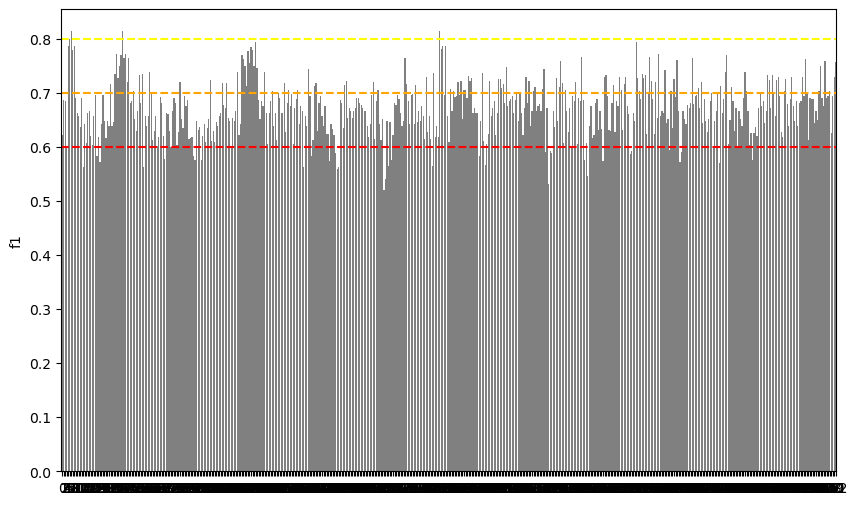

In [295]:
plt.figure(figsize=(10, 6))
sns.barplot(x = results_df.index, y='f1', color='grey', data=results_df)
plt.axhline(y=0.6, color='red', linestyle='--')
plt.axhline(y=0.7, color='orange', linestyle='--')
plt.axhline(y=0.8, color='yellow', linestyle='--')

In [309]:
results_df = results_df.sort_values(by = 'f1', ascending = False)
results_df.head(5)

,features,features_num,f1,roc_auc,accuracy,precision,recall,y_test,y_pred
250,"(rep_jpc, party, male_jpc, side1_gender)",4,0.813559,0.493151,0.685714,0.692308,0.986301,47 1.0 374 0.0 136 0.0 75 0.0 27...,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, ..."
6,"(male_jpc,)",1,0.813559,0.500000,0.685714,0.685714,1.000000,445 1.0 345 1.0 65 0.0 492 1.0 29...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
40,"(party, side1_gender)",2,0.813559,0.500000,0.685714,0.685714,1.000000,62 0.0 115 1.0 458 0.0 109 1.0 21...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
5,"(party,)",1,0.800000,0.500000,0.666667,0.666667,1.000000,449 1.0 177 1.0 153 0.0 22 1.0 33...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
380,"(rep_jpc, party, male_jpc, side1_gender, side0...",5,0.793103,0.479167,0.657143,0.676471,0.958333,353 1.0 125 1.0 504 1.0 226 1.0 37...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [297]:
results_df.loc[(results_df.loc[:, 'f1'] > 0.8), :]

,features,features_num,f1,roc_auc,accuracy,precision,recall,y_test,y_pred
6,"(male_jpc,)",1,0.813559,0.500000,0.685714,0.685714,1.000000,445 1.0 345 1.0 65 0.0 492 1.0 29...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
250,"(rep_jpc, party, male_jpc, side1_gender)",4,0.813559,0.493151,0.685714,0.692308,0.986301,47 1.0 374 0.0 136 0.0 75 0.0 27...,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, ..."
40,"(party, side1_gender)",2,0.813559,0.500000,0.685714,0.685714,1.000000,62 0.0 115 1.0 458 0.0 109 1.0 21...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


Confusion Matrix for Random Forest: ('male_jpc',)
[[72  0]
 [33  0]]


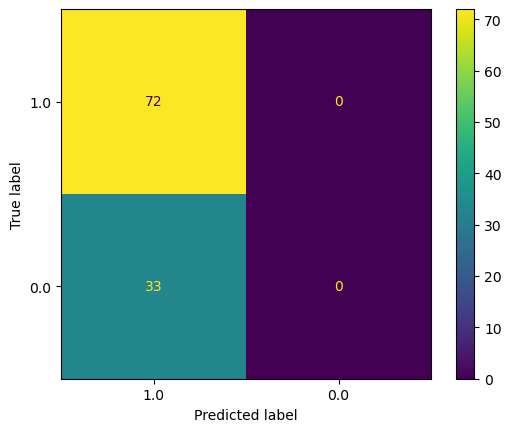

Confusion Matrix for Random Forest: ('rep_jpc', 'party', 'male_jpc', 'side1_gender')
[[72  1]
 [32  0]]


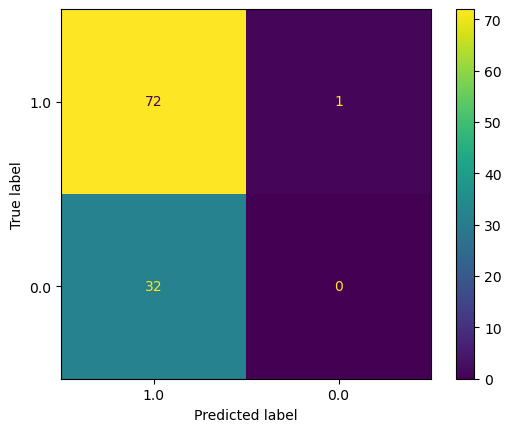

Confusion Matrix for Random Forest: ('party', 'side1_gender')
[[ 0 33]
 [ 0 72]]


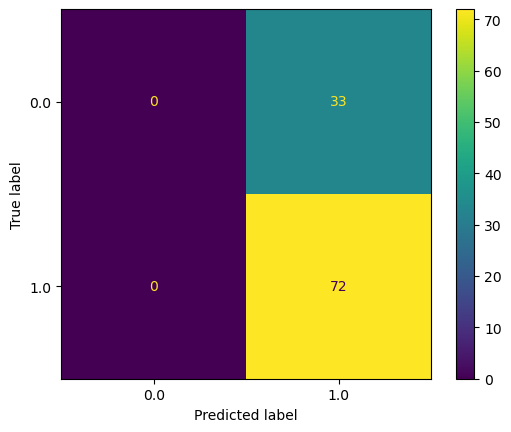

In [303]:
# Make a confusion matrix

df_matrix = results_df.head(3).reset_index(drop=True)

for i in range(len(df_matrix)):

    feature = df_matrix['features'][i]
    y_test = df_matrix['y_test'][i]
    y_pred =df_matrix['y_pred'][i]
    
    print(f"Confusion Matrix for Random Forest: {feature}")
    cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_test.unique())
    disp.plot()
    plt.show()

ROC_accuracy  
  
ROC auc < 0.5, no better than random guessing  
0.7 < ROC auc < 0.8, good performance  
ROC auc > 0.8, excellent performance  

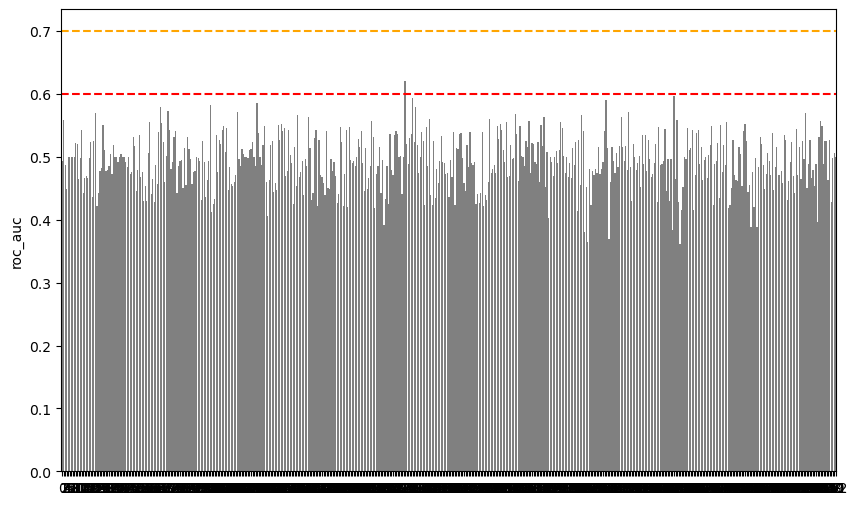

In [298]:
plt.figure(figsize=(10, 6))
sns.barplot(x = results_df.index, y='roc_auc', color='grey', data=results_df)
plt.axhline(y=0.6, color='red', linestyle='--')
plt.axhline(y=0.7, color='orange', linestyle='--')

In [308]:
results_df = results_df.sort_values(by = 'roc_auc', ascending = False)
results_df.head(5)

,features,features_num,f1,roc_auc,accuracy,precision,recall,y_test,y_pred
227,"(num_utterances, develop_time, male_jpc, side1...",4,0.763889,0.620628,0.676190,0.723684,0.808824,418 0.0 320 1.0 507 1.0 39 1.0 21...,"[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ..."
405,"(text_len, text_pre_len, develop_time, rep_jpc...",6,0.724638,0.597377,0.638095,0.714286,0.735294,285 0.0 26 0.0 262 0.0 14 1.0 73...,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, ..."
232,"(num_utterances, rep_jpc, party, side0_gender)",4,0.696970,0.594444,0.619048,0.638889,0.766667,133 1.0 257 1.0 226 1.0 224 0.0 58...,"[0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ..."
360,"(num_utterances, develop_time, rep_jpc, party,...",5,0.732394,0.590539,0.638095,0.753623,0.712329,231 1.0 338 1.0 141 1.0 426 1.0 13...,"[1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, ..."
129,"(text_len, text_pre_len, num_utterances, devel...",4,0.744828,0.585714,0.647619,0.720000,0.771429,300 1.0 191 1.0 157 0.0 467 1.0 39...,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, ..."


In [305]:
results_df.loc[(results_df.loc[:, 'roc_auc'] > 0.6), :]

,features,features_num,f1,roc_auc,accuracy,precision,recall,y_test,y_pred
227,"(num_utterances, develop_time, male_jpc, side1...",4,0.763889,0.620628,0.67619,0.723684,0.808824,418 0.0 320 1.0 507 1.0 39 1.0 21...,"[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ..."


In [306]:
results_df.loc[(results_df.loc[:, 'roc_auc'] > 0.7), :]

,features,features_num,f1,roc_auc,accuracy,precision,recall,y_test,y_pred


Confusion Matrix

Confusion Matrix for Random Forest: ('num_utterances', 'develop_time', 'male_jpc', 'side1_gender')
[[16 21]
 [13 55]]


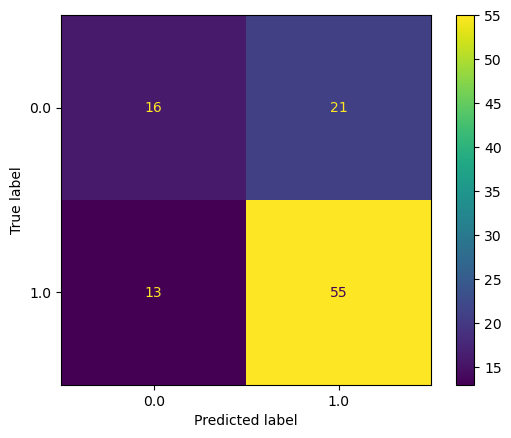

Confusion Matrix for Random Forest: ('text_len', 'text_pre_len', 'develop_time', 'rep_jpc', 'male_jpc', 'side0_gender')
[[17 20]
 [18 50]]


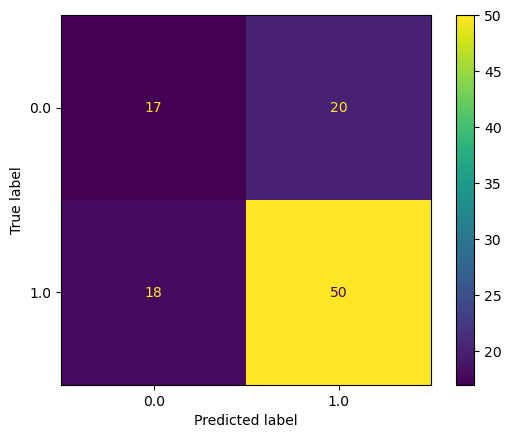

Confusion Matrix for Random Forest: ('num_utterances', 'rep_jpc', 'party', 'side0_gender')
[[46 14]
 [26 19]]


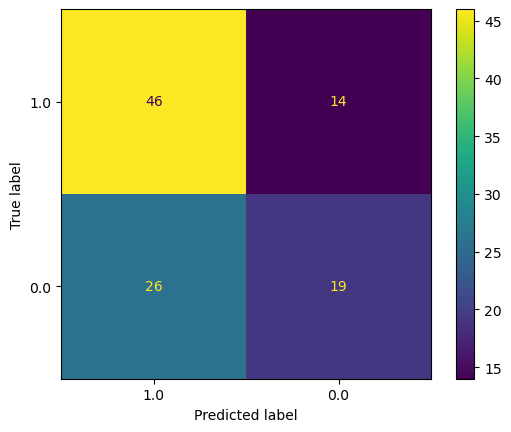

In [307]:
# Make a confusion matrix

df_matrix = results_df.head(3).reset_index(drop=True)

for i in range(len(df_matrix)):

    feature = df_matrix['features'][i]
    y_test = df_matrix['y_test'][i]
    y_pred =df_matrix['y_pred'][i]
    
    print(f"Confusion Matrix for Random Forest: {feature}")
    cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_test.unique())
    disp.plot()
    plt.show()

For 50 epoch

In [ ]:
# results = []
# count = 0
# while(count <= 50):
#     count += 1
#     # get accu from each diff features combinations
#     for feature_lst in combinations:
#         results.append(get_accuracy(feature_lst, df_rf.loc[:,feature_lst], df_rf))

#     # get accu from ngram, bigram
#     results.append(get_accuracy(['ngram_text'], CountVectorizer().fit_transform(df['text_pre']), df))
#     results.append(get_accuracy(['bigram_text'], TfidfVectorizer().fit_transform(df['text_pre']), df))

In [ ]:
# # Create a DataFrame from the results list
# results_df = pd.DataFrame(results)
# results_df

In [ ]:
# results_df = results_df.groupby('features', as_index = False).agg({'features_num': 'mean',
#                                                       'accuracy': 'mean',
#                                                       'f1': 'mean',
#                                                       'precision': 'mean',
#                                                       'recall': 'mean',})

In [ ]:
# plt.figure(figsize=(10, 6))
# sns.barplot(x = results_df.index, y='accuracy', color='grey', data=results_df)
# plt.axhline(y=0.6, color='red', linestyle='--')
# plt.axhline(y=0.7, color='orange', linestyle='--')

In [ ]:
# results_df.loc[(results_df.loc[:, 'accuracy'] > 0.6), :].sort_values(by = 'accuracy', ascending = False)

In [ ]:
# results_df.loc[(results_df.loc[:, 'accuracy'] > 0.7), :]

## With text

In [353]:
results = []
i = 0

# get accu from each diff features combinations
for feature_lst in combinations:
#     print(feature_lst)
    tfidf = TfidfVectorizer(min_df=10, max_df=0.8)
    X_text = tfidf.fit_transform(df['text_pre'])

    for feature in feature_lst:
        X_add_fea = np.array(df_rf[feature]).reshape(-1, 1)
        X = np.hstack((X_text.toarray(), X_add_fea))
        
    results.append(get_accuracy(feature_lst, X, df))
#     i += 1
#     if i == 2:
#         break
# get accu from ngram, bigram
results.append(get_accuracy(['ngram_text'], CountVectorizer().fit_transform(df['text_pre']), df))
    
results.append(get_accuracy(['bigram_text'], TfidfVectorizer().fit_transform(df['text_pre']), df))

In [354]:
# Create a DataFrame from the results list
results_df = pd.DataFrame(results)
results_df

,features,features_num,f1,roc_auc,accuracy,precision,recall,y_test,y_pred
0,"(text_len,)",1,0.771930,0.485294,0.628571,0.640777,0.970588,70 0.0 568 0.0 445 1.0 54 0.0 79...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,"(text_pre_len,)",1,0.779070,0.478571,0.638095,0.656863,0.957143,437 1.0 519 0.0 573 1.0 293 1.0 46...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,"(num_utterances,)",1,0.763636,0.535714,0.628571,0.617647,1.000000,364 1.0 551 1.0 80 1.0 575 1.0 38...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,"(develop_time,)",1,0.773810,0.518065,0.638095,0.637255,0.984848,398 1.0 246 0.0 226 0.0 421 0.0 36...,"[1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,"(rep_jpc,)",1,0.746988,0.489423,0.600000,0.613861,0.953846,109 1.0 305 0.0 79 0.0 73 0.0 40...,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, ..."
...,...,...,...,...,...,...,...,...,...
508,"(text_len, num_utterances, develop_time, rep_j...",8,0.761905,0.453981,0.619048,0.673684,0.876712,91 1.0 418 0.0 359 0.0 570 1.0 52...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
509,"(text_pre_len, num_utterances, develop_time, r...",8,0.739394,0.496032,0.590476,0.598039,0.968254,433 1.0 17 0.0 527 0.0 282 1.0 49...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
510,"(text_len, text_pre_len, num_utterances, devel...",9,0.751515,0.508765,0.609524,0.613861,0.968750,467 1.0 418 0.0 184 1.0 31 0.0 31...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
511,"(ngram_text,)",1,0.757396,0.500000,0.609524,0.609524,1.000000,328 1.0 54 0.0 302 1.0 67 1.0 40...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


f1 score  
In general, higher F1 scores are better

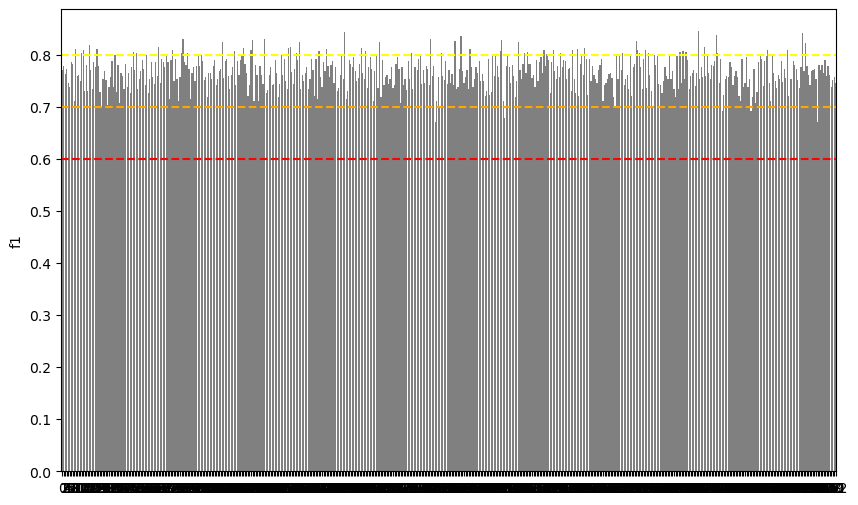

In [355]:
plt.figure(figsize=(10, 6))
sns.barplot(x = results_df.index, y='f1', color='grey', data=results_df)
plt.axhline(y=0.6, color='red', linestyle='--')
plt.axhline(y=0.7, color='orange', linestyle='--')
plt.axhline(y=0.8, color='yellow', linestyle='--')

In [356]:
results_df = results_df.sort_values(by = 'f1', ascending = False)
results_df.head(5)

,features,features_num,f1,roc_auc,accuracy,precision,recall,y_test,y_pred
421,"(text_len, num_utterances, develop_time, rep_j...",6,0.845714,0.548433,0.742857,0.762887,0.948718,67 1.0 496 1.0 407 1.0 120 1.0 45...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ..."
187,"(text_pre_len, num_utterances, develop_time, m...",4,0.844444,0.511364,0.733333,0.737864,0.987013,45 1.0 444 1.0 100 1.0 28 1.0 51...,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
490,"(text_len, num_utterances, develop_time, party...",7,0.842697,0.517806,0.733333,0.750000,0.961538,227 1.0 92 1.0 93 0.0 16 1.0 37...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
433,"(text_len, develop_time, rep_jpc, party, side1...",6,0.839080,0.553333,0.733333,0.737374,0.973333,426 1.0 194 1.0 393 1.0 342 1.0 54...,"[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ..."
264,"(text_len, text_pre_len, num_utterances, party...",5,0.837209,0.567132,0.733333,0.734694,0.972973,574 0.0 196 1.0 531 1.0 119 1.0 39...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, ..."


In [357]:
results_df.loc[(results_df.loc[:, 'f1'] > 0.8), :]

,features,features_num,f1,roc_auc,accuracy,precision,recall,y_test,y_pred
421,"(text_len, num_utterances, develop_time, rep_j...",6,0.845714,0.548433,0.742857,0.762887,0.948718,67 1.0 496 1.0 407 1.0 120 1.0 45...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ..."
187,"(text_pre_len, num_utterances, develop_time, m...",4,0.844444,0.511364,0.733333,0.737864,0.987013,45 1.0 444 1.0 100 1.0 28 1.0 51...,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
490,"(text_len, num_utterances, develop_time, party...",7,0.842697,0.517806,0.733333,0.750000,0.961538,227 1.0 92 1.0 93 0.0 16 1.0 37...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
433,"(text_len, develop_time, rep_jpc, party, side1...",6,0.839080,0.553333,0.733333,0.737374,0.973333,426 1.0 194 1.0 393 1.0 342 1.0 54...,"[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ..."
264,"(text_len, text_pre_len, num_utterances, party...",5,0.837209,0.567132,0.733333,0.734694,0.972973,574 0.0 196 1.0 531 1.0 119 1.0 39...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, ..."
...,...,...,...,...,...,...,...,...,...
321,"(text_len, rep_jpc, party, male_jpc, side0_gen...",5,0.802395,0.554952,0.685714,0.683673,0.971014,447 0.0 545 0.0 54 0.0 116 1.0 34...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
208,"(text_pre_len, develop_time, male_jpc, side0_g...",4,0.802326,0.521429,0.676190,0.676471,0.985714,150 1.0 492 1.0 188 0.0 66 1.0 38...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
237,"(num_utterances, party, male_jpc, side0_gender)",4,0.802326,0.509470,0.676190,0.690000,0.958333,227 1.0 131 1.0 403 1.0 358 0.0 48...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
185,"(text_pre_len, num_utterances, develop_time, r...",4,0.802326,0.515327,0.676190,0.683168,0.971831,492 1.0 522 1.0 490 1.0 4 0.0 31...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


Confusion Matrix for Random Forest: ('text_len', 'num_utterances', 'develop_time', 'rep_jpc', 'side1_gender', 'side0_gender')
[[74  4]
 [23  4]]


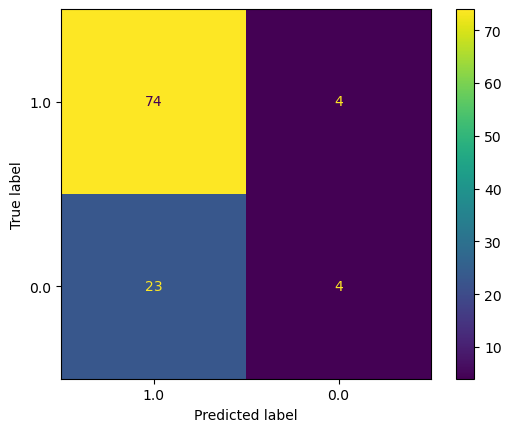

Confusion Matrix for Random Forest: ('text_pre_len', 'num_utterances', 'develop_time', 'male_jpc')
[[76  1]
 [27  1]]


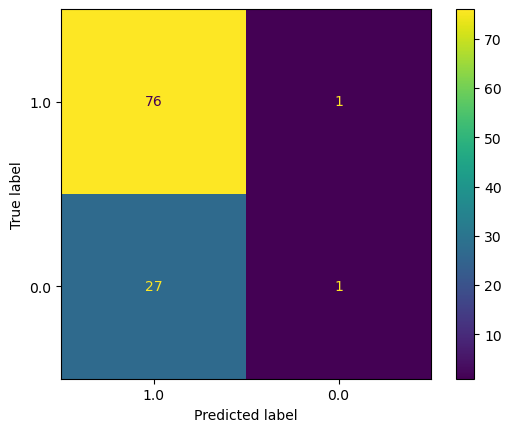

Confusion Matrix for Random Forest: ('text_len', 'num_utterances', 'develop_time', 'party', 'male_jpc', 'side1_gender', 'side0_gender')
[[75  3]
 [25  2]]


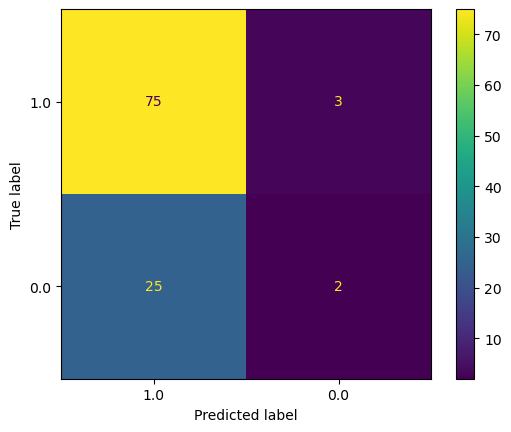

In [358]:
# Make a confusion matrix

df_matrix = results_df.head(3).reset_index(drop=True)

for i in range(len(df_matrix)):

    feature = df_matrix['features'][i]
    y_test = df_matrix['y_test'][i]
    y_pred =df_matrix['y_pred'][i]
    
    print(f"Confusion Matrix for Random Forest: {feature}")
    cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_test.unique())
    disp.plot()
    plt.show()

ROC_accuracy  
  
ROC auc < 0.5, no better than random guessing  
0.7 < ROC auc < 0.8, good performance  
ROC auc > 0.8, excellent performance  

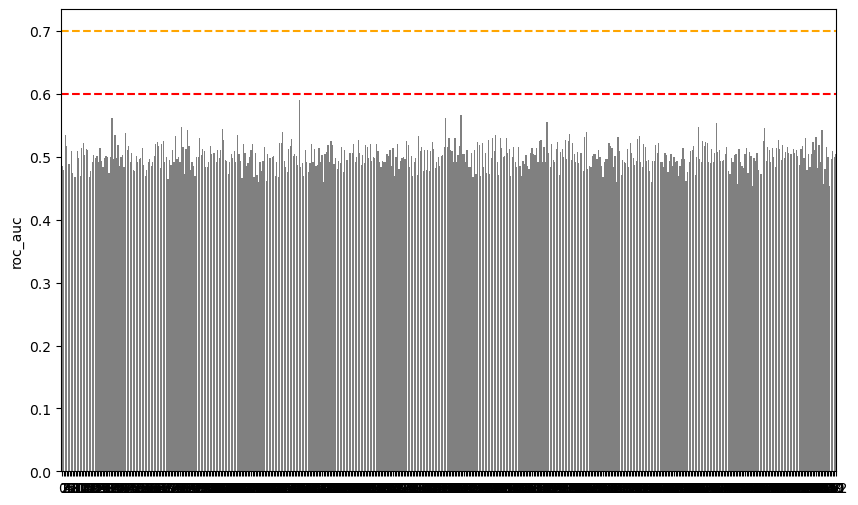

In [359]:
plt.figure(figsize=(10, 6))
sns.barplot(x = results_df.index, y='roc_auc', color='grey', data=results_df)
plt.axhline(y=0.6, color='red', linestyle='--')
plt.axhline(y=0.7, color='orange', linestyle='--')

In [360]:
results_df = results_df.sort_values(by = 'roc_auc', ascending = False)
results_df.head(5)

,features,features_num,f1,roc_auc,accuracy,precision,recall,y_test,y_pred
157,"(text_len, num_utterances, rep_jpc, side1_gender)",4,0.824242,0.590753,0.723810,0.739130,0.931507,433 1.0 184 1.0 170 1.0 137 1.0 35...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
264,"(text_len, text_pre_len, num_utterances, party...",5,0.837209,0.567132,0.733333,0.734694,0.972973,574 0.0 196 1.0 531 1.0 119 1.0 39...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, ..."
254,"(party, male_jpc, side1_gender, side0_gender)",4,0.787879,0.562500,0.666667,0.650000,1.000000,171 1.0 443 0.0 249 0.0 356 1.0 41...,"[1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
33,"(develop_time, side1_gender)",2,0.787879,0.562500,0.666667,0.650000,1.000000,269 1.0 99 1.0 36 0.0 388 1.0 10...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
321,"(text_len, rep_jpc, party, male_jpc, side0_gen...",5,0.802395,0.554952,0.685714,0.683673,0.971014,447 0.0 545 0.0 54 0.0 116 1.0 34...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [361]:
results_df.loc[(results_df.loc[:, 'roc_auc'] > 0.6), :]

,features,features_num,f1,roc_auc,accuracy,precision,recall,y_test,y_pred


In [362]:
results_df.loc[(results_df.loc[:, 'roc_auc'] > 0.7), :]

,features,features_num,f1,roc_auc,accuracy,precision,recall,y_test,y_pred


Confusion Matrix for Random Forest: ('text_len', 'num_utterances', 'rep_jpc', 'side1_gender')
[[68  5]
 [24  8]]


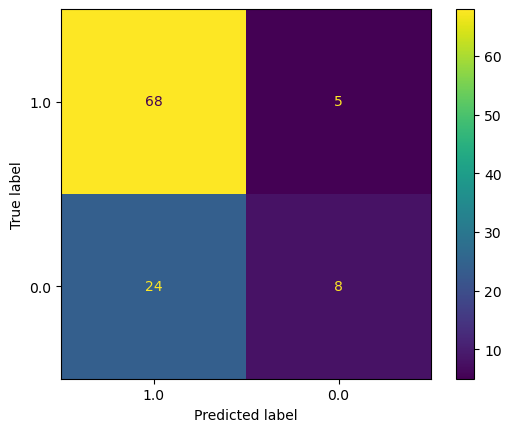

Confusion Matrix for Random Forest: ('text_len', 'text_pre_len', 'num_utterances', 'party', 'male_jpc')
[[ 5 26]
 [ 2 72]]


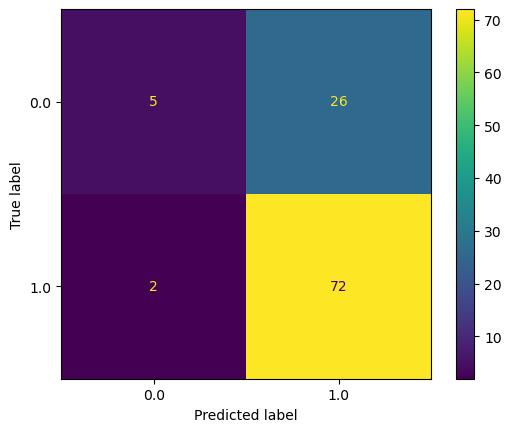

Confusion Matrix for Random Forest: ('party', 'male_jpc', 'side1_gender', 'side0_gender')
[[65  0]
 [35  5]]


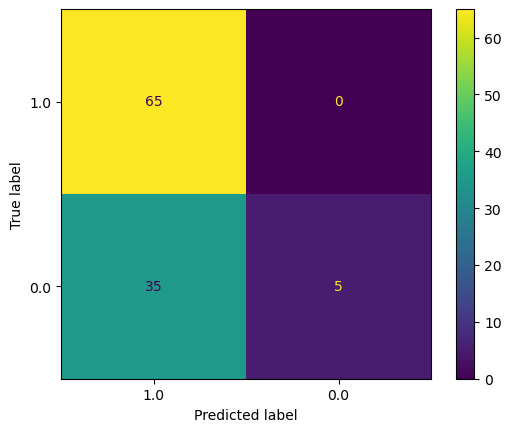

In [363]:
# Make a confusion matrix

df_matrix = results_df.head(3).reset_index(drop=True)

for i in range(len(df_matrix)):

    feature = df_matrix['features'][i]
    y_test = df_matrix['y_test'][i]
    y_pred =df_matrix['y_pred'][i]
    
    print(f"Confusion Matrix for Random Forest: {feature}")
    cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_test.unique())
    disp.plot()
    plt.show()

In [ ]:
try to balance f1 and roc_auc

In [364]:
results_df.loc[:, 'test'] = results_df.loc[:, 'f1'] + results_df.loc[:, 'roc_auc']
results_df = results_df.sort_values(by = 'test', ascending = False)
results_df.head(5)

,features,features_num,f1,roc_auc,accuracy,precision,recall,y_test,y_pred,test
157,"(text_len, num_utterances, rep_jpc, side1_gender)",4,0.824242,0.590753,0.723810,0.739130,0.931507,433 1.0 184 1.0 170 1.0 137 1.0 35...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.414996
264,"(text_len, text_pre_len, num_utterances, party...",5,0.837209,0.567132,0.733333,0.734694,0.972973,574 0.0 196 1.0 531 1.0 119 1.0 39...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, ...",1.404341
421,"(text_len, num_utterances, develop_time, rep_j...",6,0.845714,0.548433,0.742857,0.762887,0.948718,67 1.0 496 1.0 407 1.0 120 1.0 45...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",1.394147
433,"(text_len, develop_time, rep_jpc, party, side1...",6,0.839080,0.553333,0.733333,0.737374,0.973333,426 1.0 194 1.0 393 1.0 342 1.0 54...,"[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",1.392414
106,"(num_utterances, male_jpc, side1_gender)",3,0.825581,0.544246,0.714286,0.724490,0.959459,148 1.0 484 1.0 191 0.0 75 0.0 17...,"[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",1.369827


Confusion Matrix for Random Forest: ('text_len', 'num_utterances', 'rep_jpc', 'side1_gender')
[[68  5]
 [24  8]]


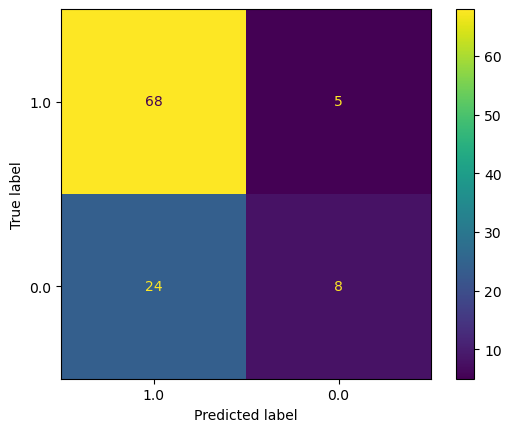

Confusion Matrix for Random Forest: ('text_len', 'text_pre_len', 'num_utterances', 'party', 'male_jpc')
[[ 5 26]
 [ 2 72]]


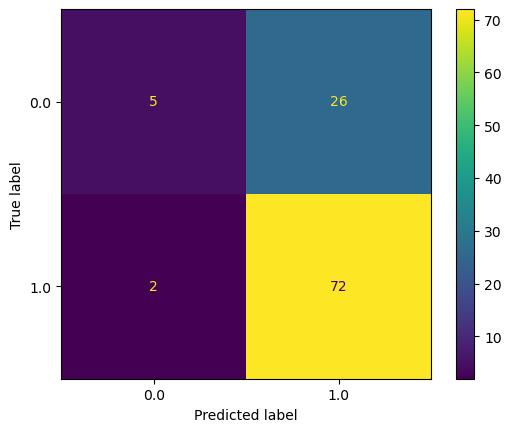

Confusion Matrix for Random Forest: ('text_len', 'num_utterances', 'develop_time', 'rep_jpc', 'side1_gender', 'side0_gender')
[[74  4]
 [23  4]]


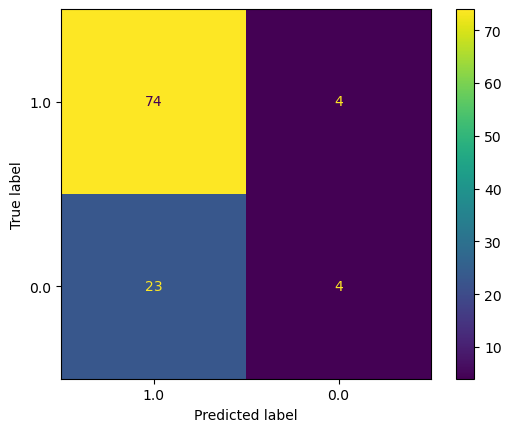

In [366]:
# Make a confusion matrix

df_matrix = results_df.head(3).reset_index(drop=True)

for i in range(len(df_matrix)):

    feature = df_matrix['features'][i]
    y_test = df_matrix['y_test'][i]
    y_pred =df_matrix['y_pred'][i]
    
    print(f"Confusion Matrix for Random Forest: {feature}")
    cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_test.unique())
    disp.plot()
    plt.show()